Essential imports:

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 11
rng = np.random.RandomState(SEED)

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(20*2, 20))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i+1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1, color='C0')
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2, color='C1')
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

# Data preparation

## 1. Toy data with numbers:

In [ ]:
num_samples_per_class = 100
batch_size = 32

# Define the samples and their labels
class1_samples = np.random.normal(loc=0.0, scale=1.0, size=(num_samples_per_class, 2))
class2_samples = np.random.normal(loc=5.0, scale=1.0, size=(num_samples_per_class, 2))

# Construct the sample_class_table (we can later encode it to bacteria species ids)
# Here we have 2 classes (=groups) and 2 features for each sample
# (we can say, bacteria species and it's abundancy)

sample_class_table = np.concatenate((class1_samples, class2_samples))
df = pd.DataFrame(sample_class_table, columns=['f1', 'f2'])
df['class'] = [0]*len(class1_samples) + [1]*len(class2_samples)
df

,f1,f2,class
0,-1.719394,-1.140627,0
1,0.957289,-0.252501,0
2,0.806790,-0.446395,0
3,-0.560682,-0.007400,0
4,-0.263161,-1.861102,0
...,...,...,...
195,4.235300,5.768848,1
196,5.546209,5.318938,1
197,3.391373,4.461420,1
198,6.077773,4.571945,1


In [ ]:
X, y = df[['f1', 'f2']].to_numpy(), df[['class']].to_numpy()

## 2. Toy data from bacteria samples:

Here we will use file with top-50 bacterial species from healthy, diabetes and diarrhea metagenomes.

In [ ]:
!wget https://raw.githubusercontent.com/checheanya/metagenome_stufff/main/data/abundance_3groups_top50.csv?token=GHSAT0AAAAAACAJWMYYAFSL5P52CVN5LTTMZA2HNGA

--2023-03-21 23:18:04--  https://raw.githubusercontent.com/checheanya/metagenome_stufff/main/data/abundance_3groups_top50.csv?token=GHSAT0AAAAAACAJWMYYAFSL5P52CVN5LTTMZA2HNGA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6713 (6.6K) [text/plain]
Saving to: ‘abundance_3groups_top50.csv?token=GHSAT0AAAAAACAJWMYYAFSL5P52CVN5LTTMZA2HNGA’

abundance_3groups_t 100%[===================>]   6.56K  --.-KB/s    in 0s      

2023-03-21 23:18:05 (54.3 MB/s) - ‘abundance_3groups_top50.csv?token=GHSAT0AAAAAACAJWMYYAFSL5P52CVN5LTTMZA2HNGA’ saved [6713/6713]



In [ ]:
!mv abundance_3groups_top50.csv?token=GHSAT0AAAAAACAJWMYYAFSL5P52CVN5LTTMZA2HNGA abundance_top50

In [ ]:
data = pd.read_csv('abundance_top50')

In [ ]:
data.head()

,bacteria,abundance,group
0,Nocardiopsis ganjiahuensis,5.040580,diabetes
1,Nocardiopsis listeri,1.799440,diabetes
2,Sphingobacterium faecium,1.748656,diabetes
3,Parabacteroides distasonis,1.667293,diabetes
4,Bacteroides ovatus,1.331201,diabetes


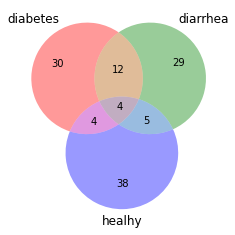

In [ ]:
from matplotlib_venn import venn3

venn3([set(data[data['group'] == 'diabetes']['bacteria'].unique()),
       set(data[data['group'] == 'diarrhea']['bacteria'].unique()),
       set(data[data['group'] == 'healthy']['bacteria'].unique())],
      set_labels = ['diabetes', 'diarrhea', 'healhy'])
plt.show()



As we can see, not much species are actually overlapping.

❗!TO THINK!❗
How it's better to represent bacteria names: OHE, label encoding, binary encoding, embedding or smth else?
OHE seems to be too sparse (--> very complex computation), label encoding can result in bias to the highest values...

We can try label encoding here:
nomalizing between 0 and 1 to apply multinomial later (to decode back to species)


In [ ]:
codes, unique_names = pd.factorize(data['bacteria'])
data['bacteria'] = (codes + 1) / len(unique_names)

In [ ]:
data['bacteria'] = data['bacteria'].astype(float)

Encoding groups in the same way:

In [ ]:
codes_g, unique_groups = pd.factorize(data['group'])
data['group'] = codes_g

In [ ]:
data.head()

,bacteria,abundance,group
0,0.008197,5.040580,0
1,0.016393,1.799440,0
2,0.024590,1.748656,0
3,0.032787,1.667293,0
4,0.040984,1.331201,0


Normalizing abundancies:

In [ ]:
# not minmax cause it gives not normal distribution with shift to 0
scaler = StandardScaler()
data['abundance'] = scaler.fit_transform(data[['abundance']].to_numpy())

In [ ]:
data.head()

,bacteria,abundance,group
0,0.008197,2.607785,0
1,0.016393,0.337153,0
2,0.024590,0.301576,0
3,0.032787,0.244575,0
4,0.040984,0.009121,0


In [ ]:
data.dtypes

bacteria     float64
abundance    float64
group          int64
dtype: object

In [ ]:
X, y = data[['bacteria', 'abundance']].to_numpy(), data[['group']].to_numpy()

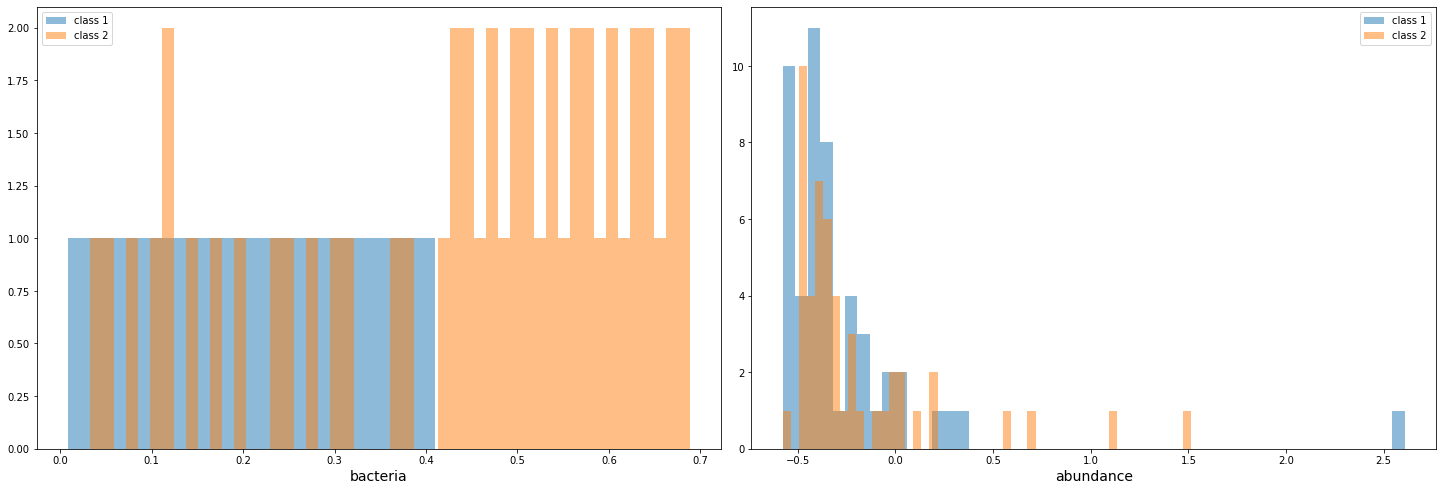

In [ ]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], ['bacteria', 'abundance'], label1="class 1", label2="class 2", bins=50)

Abundance distribution is not normal and has a heavy tail close to 0. To get rid of it we can apply quantile transformer from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). 

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=10, random_state=SEED,
                         output_distribution='normal')
ab_qt = qt.fit_transform(data[['abundance']].to_numpy())
data['ab_trf'] = ab_qt
X_qt = data[['bacteria', 'ab_trf']].to_numpy()

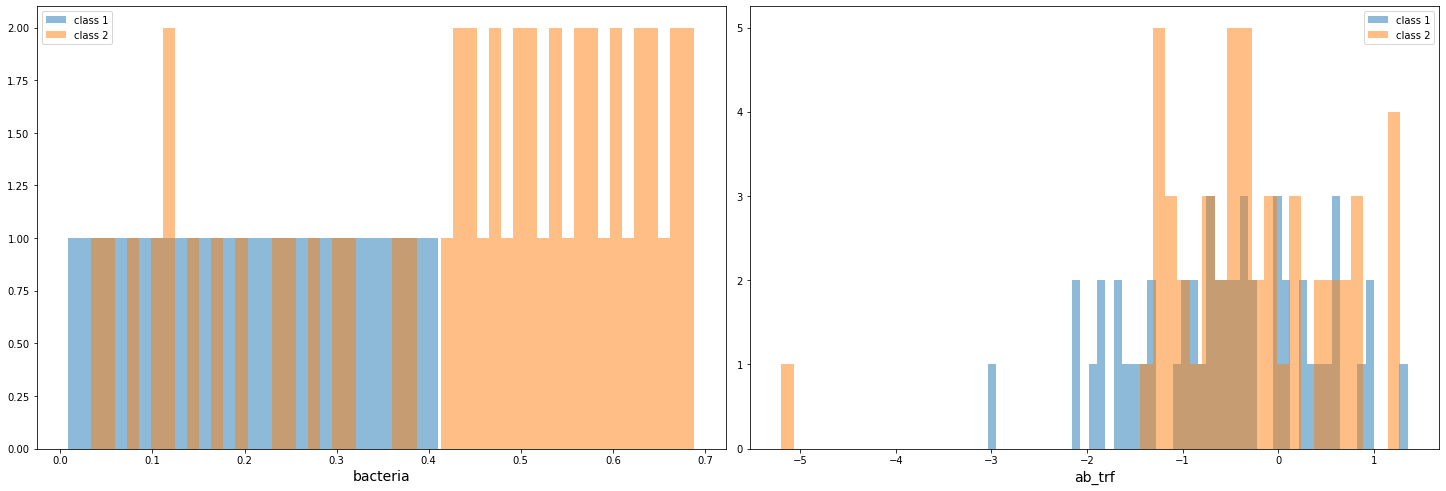

In [ ]:
plot_hists(X_qt[y[:, 0]==0], X_qt[y[:, 0]==1], ['bacteria', 'ab_trf'], label1="class 1", label2="class 2", bins=50)

Looks a bit better

In [ ]:
# I decided not to use it but will leave it here just in case / USELESS CELL ! /
dataloader = DataLoader(list(zip(X, y)), batch_size=batch_size, shuffle=True, drop_last = True)

for i, (s, l) in enumerate(dataloader):
    if i == 1:
        break
    print(s)
    print(l)

# CWGAN

Splitting test and train data:

In [ ]:
# if we're using X_qt: (if not just change to X)

X_train, X_test, y_train, y_test = train_test_split(
    X_qt, y, stratify=y, test_size=0.3, shuffle=True, random_state=SEED
    )

## Defining generator and discriminator:

Scheme:

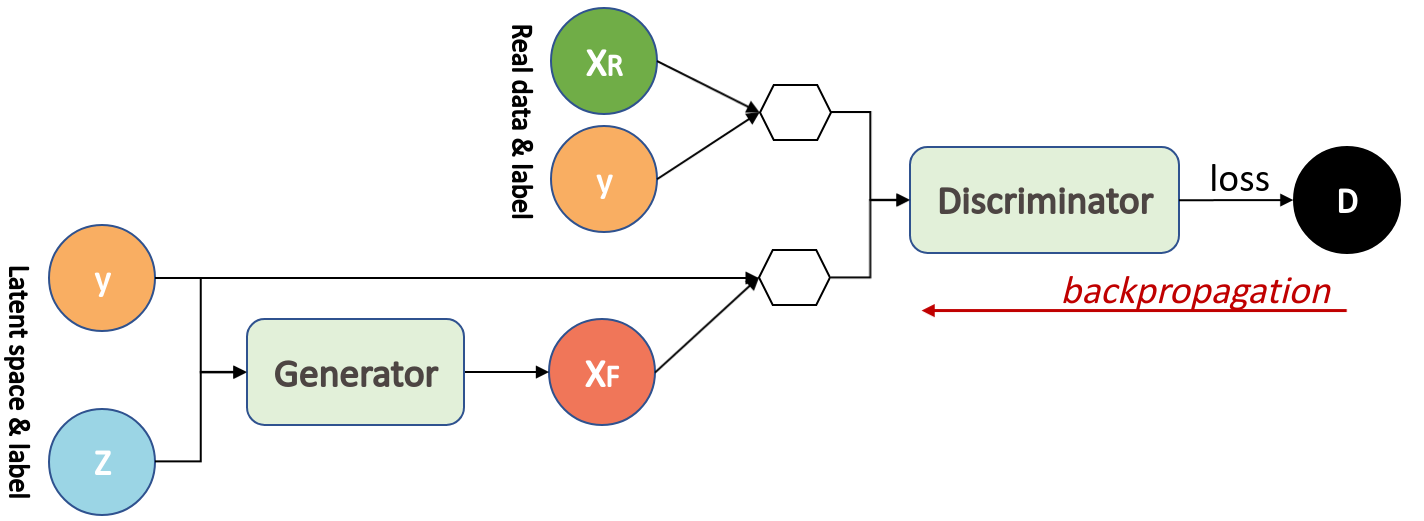

Losss function:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
# Generator model
# takes vector (1, num_features) = noise, z and conditions vector = classes, y
# returns new vector (x_hat)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_size=100):
        super(Generator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(self.n_inputs, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

# Discriminator model
# takes our vector-sample generated by generator (1, num_features), x 
# returns number 1/0 - fake or real

class Discriminator(nn.Module):
    def __init__(self, n_inputs, hidden_size=100):
        super(Discriminator, self).__init__()
        self.n_inputs = n_inputs

        self.net = nn.Sequential(
            nn.Linear(self.n_inputs, hidden_size), 
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        # set parameter limits
        for p in self.parameters():
          p.data.clamp_(-0.01, 0.01)

        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Training loop:

* p.data.clamp_(-0.01, 0.01) - restriction for the discriminator weights (p)
* n_critic - number of D training iterations for 1 training of G
* conversion from numpy to tensor \\
X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)

In [ ]:
class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10,
                 latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        # optim.Adam(discriminator.parameters(), lr=lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
        # criterion = nn.BCELoss()
    
    
    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []

        iter_i = 0

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
                ):
                
              real_batch = real_batch.to(DEVICE)
              cond_batch = cond_batch.to(DEVICE)
              
              # generation of new objects
              num_objects = real_batch.shape[0]
              Z_noise = torch.normal(0, 1, (num_objects, self.latent_dim))
              gen_objects = self.generator(Z_noise, cond_batch)

              # score calculating
              real_objects_scores, gen_objects_scores = torch.split(self.discriminator(
                  torch.cat([real_batch, gen_objects], dim=0), 
                  torch.cat([cond_batch, cond_batch], dim=0)), num_objects)

              if iter_i % self.n_critic == 0:
                # generator learning step
                self.opt_gen.zero_grad()
                gen_loss = - torch.mean(gen_objects_scores)
                gen_loss.backward()
                self.opt_gen.step()

              else:
                # discr learning step
                self.opt_disc.zero_grad()
                discr_loss = torch.mean(gen_objects_scores) - torch.mean(real_objects_scores)
                discr_loss.backward()
                self.opt_disc.step()
          
              iter_i += 1
                    
            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

Training the model:

In [ ]:
y_train.shape, type(y_train)

((105, 1), numpy.ndarray)

In [ ]:
X_train.shape, type(X_train)

((105, 2), numpy.ndarray)

In [ ]:
%%time

latent_dim = 10
generator = Generator(n_inputs=latent_dim+y.shape[1], 
                          n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

# will fall with batch size = 8, because there will be a leftover batch of size 1
fitter = Fitter(generator, discriminator, batch_size=16, n_epochs=100,
                latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train, y_train)

CPU times: user 1.74 s, sys: 0 ns, total: 1.74 s
Wall time: 2.43 s


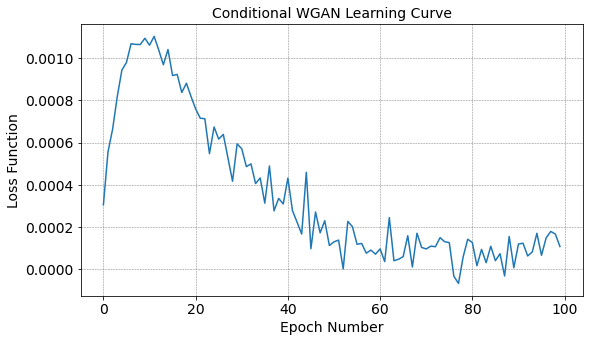

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

Looks horrible :)))

## Generating fake data:

In [ ]:
def generate(generator, y, latent_dim):

    y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
    Z_noise = torch.normal(0, 1, (len(y), latent_dim))
    X_fake_raw = generator(Z_noise, y_cond)
    X_fake = X_fake_raw.cpu().detach().numpy()

    return X_fake # numpy

In [ ]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

In [ ]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

Plotting fake vs true:

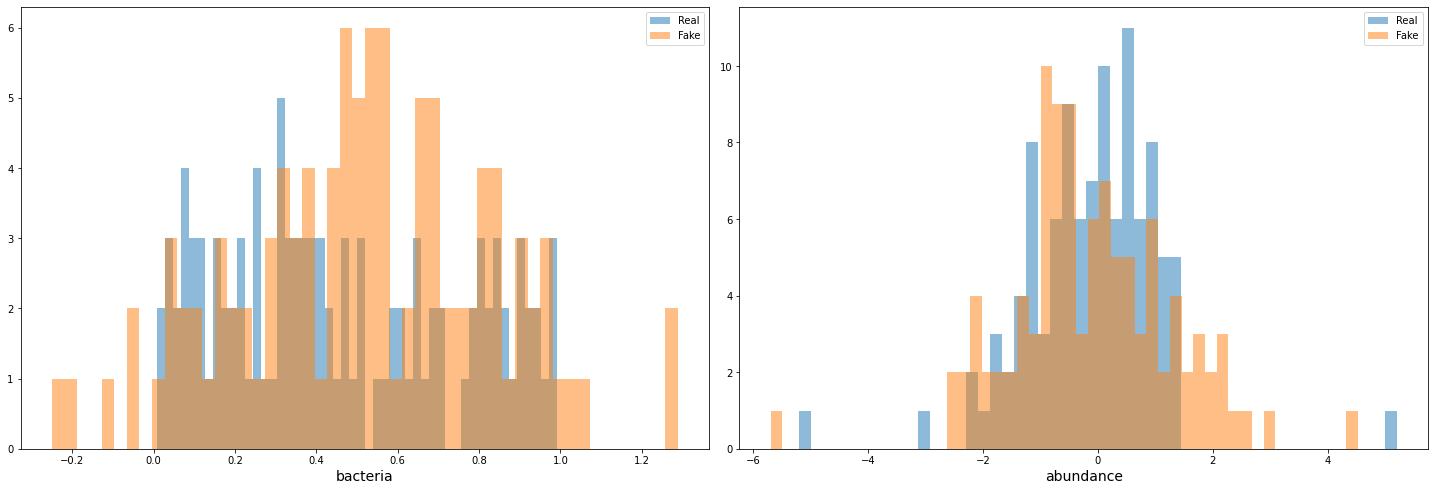

In [ ]:
plot_hists(X_train, X_fake_train, ['bacteria', 'abundance'], label1="Real", label2="Fake", bins=50)

## Metrics:

In [ ]:
# joining fake matrices in one 
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [ ]:
# trtaining classificator
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# getting predictions
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7762287334593573


# CVAE

## Defining the network:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size, hidden_size=100):
        super(Encoder, self).__init__()
        
        self.n_inputs = n_inputs
        self.lat_size = lat_size

        self.enc_net = nn.Sequential(
            nn.Linear(self.n_inputs, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        
        self.mu = nn.Linear(hidden_size, self.lat_size)
        self.log_sigma =nn.Linear(hidden_size, self.lat_size)
        
    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)

        return mu, log_sigma 


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_size=100):
        super(Decoder, self).__init__()
        
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.dec_net = nn.Sequential(
            nn.Linear(self.n_inputs, hidden_size), 
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.n_outputs),
        )
        
    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)

        return x_rec

In [ ]:
class VAEFitter(object):
    
    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1,
                 lr=0.0001, KL_weight=0.001):
        
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight
        
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        
        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)
        
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x) 
        return KL*self.KL_weight + recon_loss
    
    def compute_loss(self, x_batch, cond_batch):
        
        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decoder(z, cond_batch)

        loss = self.custom_loss(x_batch, rec_x, mu, log_sigma)
        return loss
    
    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)
                
                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

In [ ]:
%%time

latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(encoder, decoder, batch_size=16, n_epochs=100, latent_dim=latent_dim, lr=0.001, KL_weight=0.001)
vae_fitter.fit(X_train, y_train)

CPU times: user 1.73 s, sys: 0 ns, total: 1.73 s
Wall time: 1.73 s


Both here and in CWGAN it's better to use small batches since the toy dataset is not large. However, we have to perform a pure grid search for normal data. As it was written in the cNODE paper, the bacterial data in metagenomics is usually very sparse - we have many species that are special for few classes --> for many other classes it'll be 0. 

CVAE learning curve:

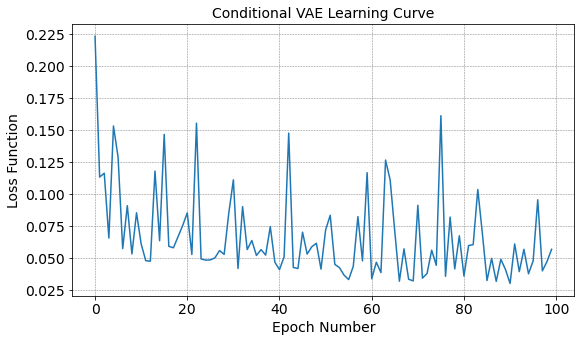

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional VAE Learning Curve", size=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

That looks better! - for toy with numbers \\
That looks even worse (don't look, you'll cry....) - for toy bacteria

## Generating fake data:

Function for generation

In [ ]:
def generate(decoder, y, latent_dim):

    y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
    Z_noise = torch.normal(0, 1, (len(y), latent_dim))
    X_fake_raw = decoder(Z_noise, y_cond)
    X_fake = X_fake_raw.cpu().detach().numpy()

    return X_fake # numpy

Generation and comparison of fake data:

In [ ]:
X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)
X_fake_test = generate(vae_fitter.decoder, y_test, latent_dim)

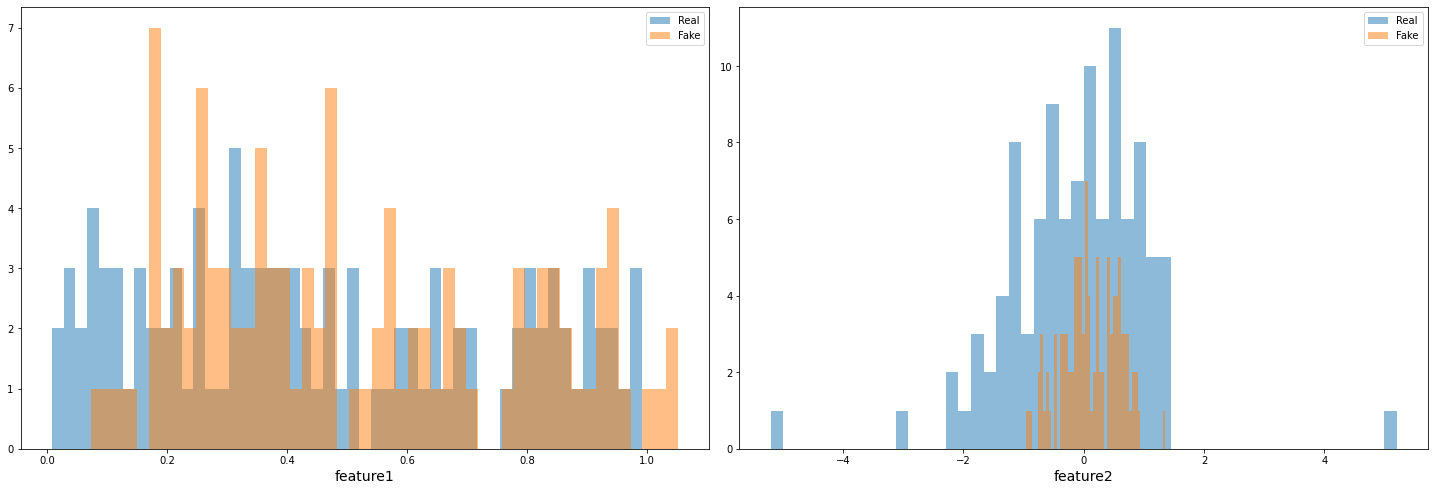

In [ ]:
plot_hists(X_train, X_fake_train, ['feature1', 'feature2'], label1="Real", label2="Fake", bins=50)

Looks better but still very bad....
(comments are for toy numbers)

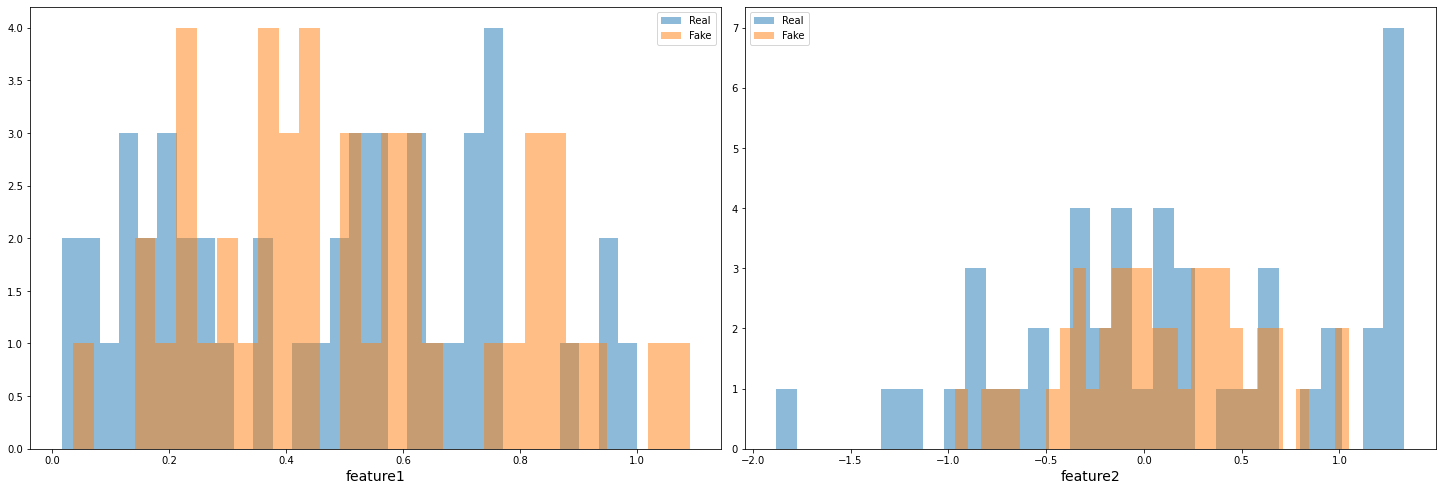

In [ ]:
plot_hists(X_test, X_fake_test, ['feature1', 'feature2'], label1="Real", label2="Fake", bins=30)

## Metrics:

In [ ]:
# merging datasets
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [ ]:
# training the classificator
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# getting prognosis
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.81734404536862


# Hyperparameters selection

## For CVAE

1. Batch size

In [ ]:
latent_dim = 10

# change accorning to the dataset size!
# do not use bs = 8 for the bacteris toy!
for batch_size in [8, 16, 32, 64]:
  # training
  encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
  decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

  vae_fitter = VAEFitter(encoder, decoder, batch_size, n_epochs=100, latent_dim=latent_dim, lr = 0.001, KL_weight=0.001)
  vae_fitter.fit(X_train, y_train)

  # fake matrix creating 
  X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)

  # concatenating
  XX_train = np.concatenate((X_fake_train, X_train), axis=0)
  XX_test = np.concatenate((X_fake_test, X_test), axis=0)

  yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
  yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

  # classifier
  clf = GradientBoostingClassifier()
  clf.fit(XX_train, yy_train)

  # получаем прогнозы
  yy_test_proba = clf.predict_proba(XX_test)[:, 1]

  auc = roc_auc_score(yy_test, yy_test_proba)
  print("Batch size = ", batch_size)
  print("ROC AUC = ", auc)

Batch size =  8
ROC AUC =  0.7561111111111112
Batch size =  16
ROC AUC =  0.7193055555555555
Batch size =  32
ROC AUC =  0.6901388888888889
Batch size =  64
ROC AUC =  0.6580555555555555


2. Learning rate

!! CHANGE BS TO 8 !!!

In [ ]:
for lr in [0.05, 0.01, 0.005, 0.001, 0.0005]:
  # training
  encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
  decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

  vae_fitter = VAEFitter(encoder, decoder, lr = lr, batch_size=350, n_epochs=100, latent_dim=latent_dim, KL_weight=0.001)
  vae_fitter.fit(X_train, y_train)

  # fake matrix creating 
  X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)

  # concatenating
  XX_train = np.concatenate((X_fake_train, X_train), axis=0)
  XX_test = np.concatenate((X_fake_test, X_test), axis=0)

  yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
  yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

  # classifier
  clf = GradientBoostingClassifier()
  clf.fit(XX_train, yy_train)

  # получаем прогнозы
  yy_test_proba = clf.predict_proba(XX_test)[:, 1]

  auc = roc_auc_score(yy_test, yy_test_proba)
  print("Learning rate = ", lr)
  print("ROC AUC = ", auc)

Learning rate =  0.05
ROC AUC =  0.776388888888889
Learning rate =  0.01
ROC AUC =  0.6295833333333333
Learning rate =  0.005
ROC AUC =  0.5902777777777778
Learning rate =  0.001
ROC AUC =  0.6244444444444445
Learning rate =  0.0005
ROC AUC =  0.6215277777777778


## For CWGAN:

In [ ]:
def generate_wgan(generator, y, latent_dim):

    y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
    Z_noise = torch.normal(0, 1, (len(y), latent_dim))
    X_fake_raw = generator(Z_noise, y_cond)
    X_fake = X_fake_raw.cpu().detach().numpy()

    return X_fake # numpy

In [ ]:
for batch_size in [8, 16, 32]:
  # training
  generator     = Generator(n_inputs=latent_dim+y.shape[1], 
                            n_outputs=X_train.shape[1])
  discriminator = Discriminator(n_inputs=X_train.shape[1]+y.shape[1])

  fitter = Fitter(generator, discriminator, batch_size=batch_size, n_epochs=100, latent_dim=latent_dim, lr=0.0001, n_critic=5)
  fitter.fit(X_train, y_train)

  # fake matrix creating 
  X_fake_train = generate_wgan(fitter.generator, y_train, latent_dim)

  # concatenating
  XX_train = np.concatenate((X_fake_train, X_train), axis=0)
  XX_test = np.concatenate((X_fake_test, X_test), axis=0)

  yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
  yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

  # classifier
  clf = GradientBoostingClassifier()
  clf.fit(XX_train, yy_train)

  # получаем прогнозы
  yy_test_proba = clf.predict_proba(XX_test)[:, 1]

  auc = roc_auc_score(yy_test, yy_test_proba)
  print("Batch size = ", batch_size)
  print("ROC AUC = ", auc)

Batch size =  8
ROC AUC =  0.7793055555555556
Batch size =  16
ROC AUC =  0.5629166666666666
Batch size =  32
ROC AUC =  0.7019444444444444


In [ ]:
for lr in [0.05, 0.01, 0.005, 0.001, 0.0005]:
  # training
  generator     = Generator(n_inputs=latent_dim+y.shape[1], 
                            n_outputs=X_train.shape[1])
  discriminator = Discriminator(n_inputs=X_train.shape[1]+y.shape[1])

  fitter = Fitter(generator, discriminator, batch_size=300, n_epochs=100, latent_dim=latent_dim, lr=lr, n_critic=5)
  fitter.fit(X_train, y_train)

  # fake matrix creating 
  X_fake_train = generate_wgan(fitter.generator, y_train, latent_dim)

  # concatenating
  XX_train = np.concatenate((X_fake_train, X_train), axis=0)
  XX_test = np.concatenate((X_fake_test, X_test), axis=0)

  yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
  yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

  # classifier
  clf = GradientBoostingClassifier()
  clf.fit(XX_train, yy_train)

  # получаем прогнозы
  yy_test_proba = clf.predict_proba(XX_test)[:, 1]

  auc = roc_auc_score(yy_test, yy_test_proba)
  print("Learning rate = ", lr)
  print("ROC AUC = ", auc)

Learning rate =  0.05
ROC AUC =  0.7698611111111111
Learning rate =  0.01
ROC AUC =  0.7295833333333333
Learning rate =  0.005
ROC AUC =  0.6291666666666667
Learning rate =  0.001
ROC AUC =  0.7379166666666667
Learning rate =  0.0005
ROC AUC =  0.6023611111111111


# TODO:

* add condition that sum(abundancies) = 1!
* how to decode back to bacteria names... (I mean, I know, but have to implement it + I have a feeling that nothing will match :))
* try normalizing flows
* make better hyperparameters selection
* try with OHE
* how to interpret abundancies < 0?...
* change loss function: e.g to 0-1 linear, >1 exp (fast growing)
* fix bacteria array and predict only abundancies
* try cos metrix